In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
from scipy import stats

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [4]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "futures_dataset_monthly"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    # "naive",
    # "mvo",
    # "bl",
    "linear-ridge",
]

In [5]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] #+ pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [6]:
import numpy as np
import pandas as pd

data_factors = pd.read_csv('data/inputs/fredmd_factors_raw.csv')
transformation_codes = data_factors.iloc[0]
data_factors = data_factors.drop(0)
transformation_codes = transformation_codes.to_dict()
del transformation_codes['sasdate']

small = 1e-6
for column in data_factors.columns:
    if column in transformation_codes:
        match int(transformation_codes[column]):
            case 1:
                data_factors[column] = data_factors[column]

            case 2: # First difference: x(t)-x(t-1)
                data_factors[column] = data_factors[column].diff()

            case 3: # Second difference: (x(t)-x(t-1))-(x(t-1)-x(t-2))
                data_factors[column] = data_factors[column].diff().diff()

            case 4: # Natural log: ln(x)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)

            case 5: # First difference of natural log: ln(x)-ln(x-1)
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff()

            case 6: # Second difference of natural log: (ln(x)-ln(x-1))-(ln(x-1)-ln(x-2))
                data_factors[column] = data_factors[column].apply(lambda x: np.log(x) if x > small else None)
                data_factors[column] = data_factors[column].diff().diff()

            case 7: # First difference of percent change: (x(t)/x(t-1)-1)-(x(t-1)/x(t-2)-1)
                data_factors[column] = data_factors[column].pct_change()
                data_factors[column] = data_factors[column].diff()

data_factors = data_factors.drop([1, 2]).reset_index(drop=True)

data_factors = data_factors.ffill()
data_factors = data_factors.fillna(0.0)

data_factors['sasdate'] = pd.to_datetime(data_factors['sasdate'], format='%m/%d/%Y')
data_factors = data_factors.rename(columns={'sasdate': 'date'})
data_factors = data_factors.set_index('date')


from sklearn.decomposition import PCA
import matplotlib.pyplot as plot

df_normalized = data_factors

# You must normalize the data before applying the fit method
df_normalized=(df_normalized - df_normalized.mean()) / df_normalized.std()
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df_normalized.columns)
print(loadings)

DESIRE_EXPLAINED_VARIANCE = 0.95
total_explained_variance = 0.0
for i, x in enumerate(pca.explained_variance_ratio_):
    total_explained_variance += x
    if total_explained_variance >= DESIRE_EXPLAINED_VARIANCE:
        print(f"Number of components to explain {DESIRE_EXPLAINED_VARIANCE * 100}% variance: {i+1}")
        break
n_components = i+1

# Use the top n components to transform the data
pca = PCA(n_components=df_normalized.shape[1])
pca.fit(df_normalized)
df_transformed = pd.DataFrame(pca.transform(df_normalized),
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=df_normalized.index)
df_transformed = df_transformed[['PC%s' % _ for _ in range(n_components)]]

print(df_transformed)

memory_data = df_transformed

                      PC0       PC1       PC2       PC3       PC4       PC5  \
RPI              0.032678 -0.047984  0.000752 -0.025343  0.063781 -0.045892   
W875RX1         -0.112550 -0.068211 -0.038119  0.032999  0.006149  0.006541   
DPCERA3M086SBEA -0.146550  0.027131 -0.060616  0.042417 -0.018647 -0.143320   
CMRMTSPLx       -0.135673 -0.008126 -0.053135  0.014012  0.024570 -0.093309   
RETAILx         -0.127633  0.065554 -0.019088  0.035344  0.000766 -0.146614   
...                   ...       ...       ...       ...       ...       ...   
UMCSENTx        -0.037855  0.012142 -0.030014 -0.014400 -0.012411 -0.098975   
DTCOLNVHFNM     -0.002451  0.009939  0.011267 -0.016205 -0.015283 -0.058104   
DTCTHFNM        -0.006255  0.013653  0.012419 -0.018355 -0.013001 -0.032122   
INVEST          -0.015517  0.016652 -0.007961  0.011221 -0.015233  0.019285   
VIXCLSx          0.052323  0.001555  0.009238  0.039914 -0.001340 -0.121704   

                      PC6       PC7       PC8      

In [7]:
# get regimes
#memory_dir_name = "kmeans_elbow"
memory_dir_name = 'kmeans'
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [8]:
pd.DataFrame(memory_data.columns)

,0
0,PC0
1,PC1
2,PC2
3,PC3
4,PC4
...,...
56,PC56
57,PC57
58,PC58
59,PC59


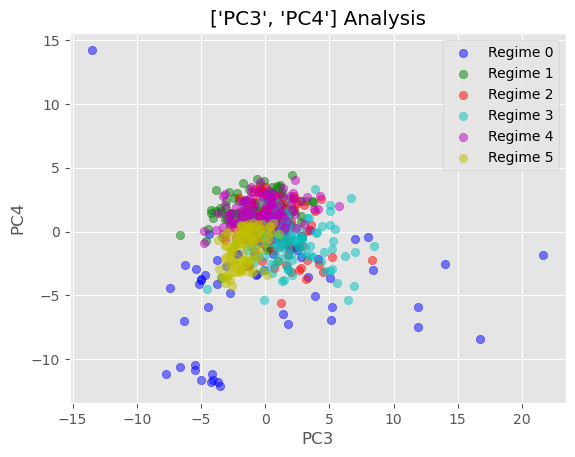

In [9]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_vars = ['PC3', 'PC4']

plt.clf()
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i in range(6):
    plt.scatter(memory_data[macro_vars[0]][:-1][regimes['cluster_step697'] == i], memory_data[macro_vars[1]][:-1][regimes['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
plt.title(f"{macro_vars} Analysis")
plt.xlabel(macro_vars[0])
plt.ylabel(macro_vars[1])
plt.legend()
plt.show()

In [10]:
# etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
# macro_var = 'PC0'

# for etf in etfs:
#     plt.clf()
#     colors = ['b', 'g', 'r', 'c', 'm', 'y']
#     for i in range(6):
#         plt.scatter(memory_data[-275:][macro_var][regimes[-275:]['cluster_step697'] == i],
#                     returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
#     plt.title(f"{etf} / {macro_var} Analysis")
#     plt.xlabel(macro_var)
#     plt.ylabel(etf + " Returns")
#     plt.legend()
#     plt.show()

In [11]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
style_map = {}
for method in portfolio_methods:
    print(method)
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        style_map[method + dir.split('/')[-1][7:-4]] = f"{cur_color}{cur_line_type}"
        print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

linear-ridge
linear-ridge results_lo_5.pkl


In [14]:
%config InlineBackend.figure_format = 'retina'
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
# spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
# concat_list = [equal_weight_cumm_returns, spy_cumm_returns]
concat_list = [equal_weight_cumm_returns]

model_list = all_portfolio_returns_df["models"].unique()
model_list = [
    # 'naive_lns_2',
    # 'naive_mx_2',
    # 'naive_los_2',
    # 'naive_lo_2',
    # 'naive_lns_3',
    # 'naive_mx_3',
    # 'naive_los_3',
    # 'naive_lo_3',
    # 'naive_mx_4',
    # 'naive_lns_4',
    # 'naive_los_4',
    # 'naive_lo_4',

    # 'naive_lns_2_rand',
    # 'naive_mx_2_rand',
    # 'naive_los_2_rand',
    # 'naive_lo_2_rand',
    # 'naive_lns_3_rand',
    # 'naive_mx_3_rand',
    # 'naive_los_3_rand',
    # 'naive_lo_3_rand',
    # 'naive_lns_4_rand',
    # 'naive_mx_4_rand',
    # 'naive_los_4_rand',
    # 'naive_lo_4_rand',

    # 'mvo_lns_2',
    # 'mvo_lo_2',
    # 'mvo_lns_3',
    # 'mvo_lo_3',
    # 'mvo_lns_4',
    # 'mvo_lo_4',
    # 'mvo_lns_5',
    # 'mvo_lo_5',

    # 'bl_lns_2',
    # 'bl_lo_2',
    # 'bl_lns_3',
    # 'bl_lo_3',
    # 'bl_lns_4',
    # 'bl_lo_4',
    # 'bl_lns_5',
    # 'bl_lo_5',

    # 'bl_lns_2_rand',
    # 'bl_lo_2_rand',
    # 'bl_lns_3_rand',
    # 'bl_lo_3_rand',
    # 'bl_lns_4_rand',
    # 'bl_lo_4_rand',
    # 'bl_lns_5_rand',
    # 'bl_lo_5_rand',

    # 'linear-ridge_lns_2',
    # 'linear-ridge_mx_2',
    # 'linear-ridge_los_2',
    # 'linear-ridge_lo_2',
    # 'linear-ridge_lns_3',
    # 'linear-ridge_mx_3',
    # 'linear-ridge_los_3',
    # 'linear-ridge_lo_3',
    # 'linear-ridge_lns_4',
    # 'linear-ridge_mx_4',
    # 'linear-ridge_los_4',
    # 'linear-ridge_lo_4',
    # 'linear-ridge_lns_5',
    # 'linear-ridge_mx_5',
    # 'linear-ridge_los_5',
    'linear-ridge_lo_5',

    # 'linear-ridge_lns_2_rand',
    # 'linear-ridge_mx_2_rand',
    # 'linear-ridge_los_2_rand',
    # 'linear-ridge_lo_2_rand',
    # 'linear-ridge_lns_3_rand',
    # 'linear-ridge_mx_3_rand',
    # 'linear-ridge_los_3_rand',
    # 'linear-ridge_lo_3_rand',
    # 'linear-ridge_lns_4_rand',
    # 'linear-ridge_mx_4_rand',
    # 'linear-ridge_los_4_rand',
    # 'linear-ridge_lo_4_rand',
    # 'linear-ridge_lns_5_rand',
    # 'linear-ridge_mx_5_rand',
    # 'linear-ridge_los_5_rand',
    # 'linear-ridge_lo_5_rand',
]
print(style_map)
styles = ['m', 'c'] + [style_map[model] for model in model_list]
for model in model_list:
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    # ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # # Place the legend outside the plot
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

{'linear-ridge_lo_5': 'r-'}


In [15]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

In [16]:
all_summary_statistics_df

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
linear-ridge_lo_5,3.738443,17.41375,0.743685,2.043239,-2.063118,-10.946311,0.56872


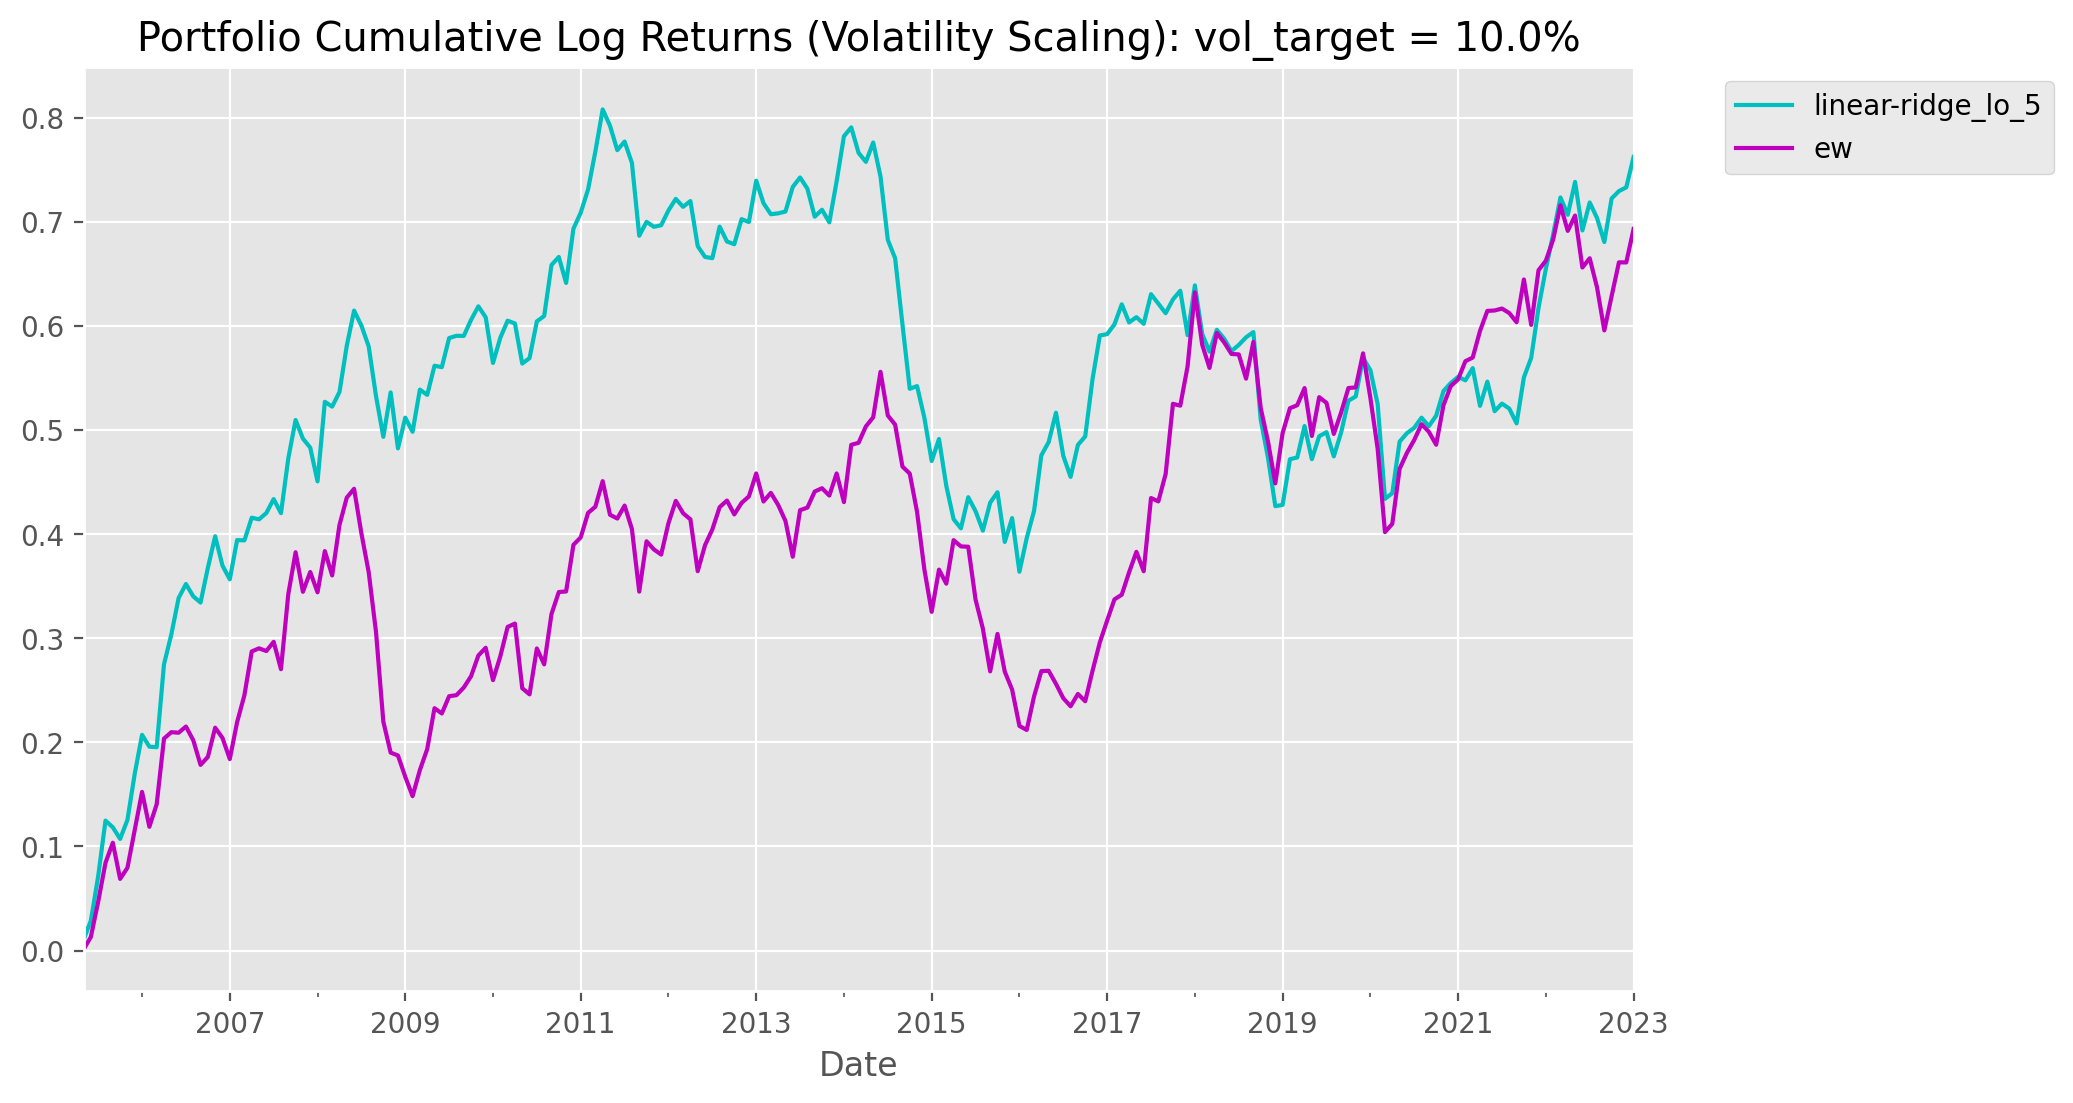

In [17]:
returns = pd.concat(concat_list, axis=1)
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index
order_style = list(cum_voladj_returns.mean(axis=0).argsort())
ax = cum_voladj_returns[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%", xlabel="Date")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

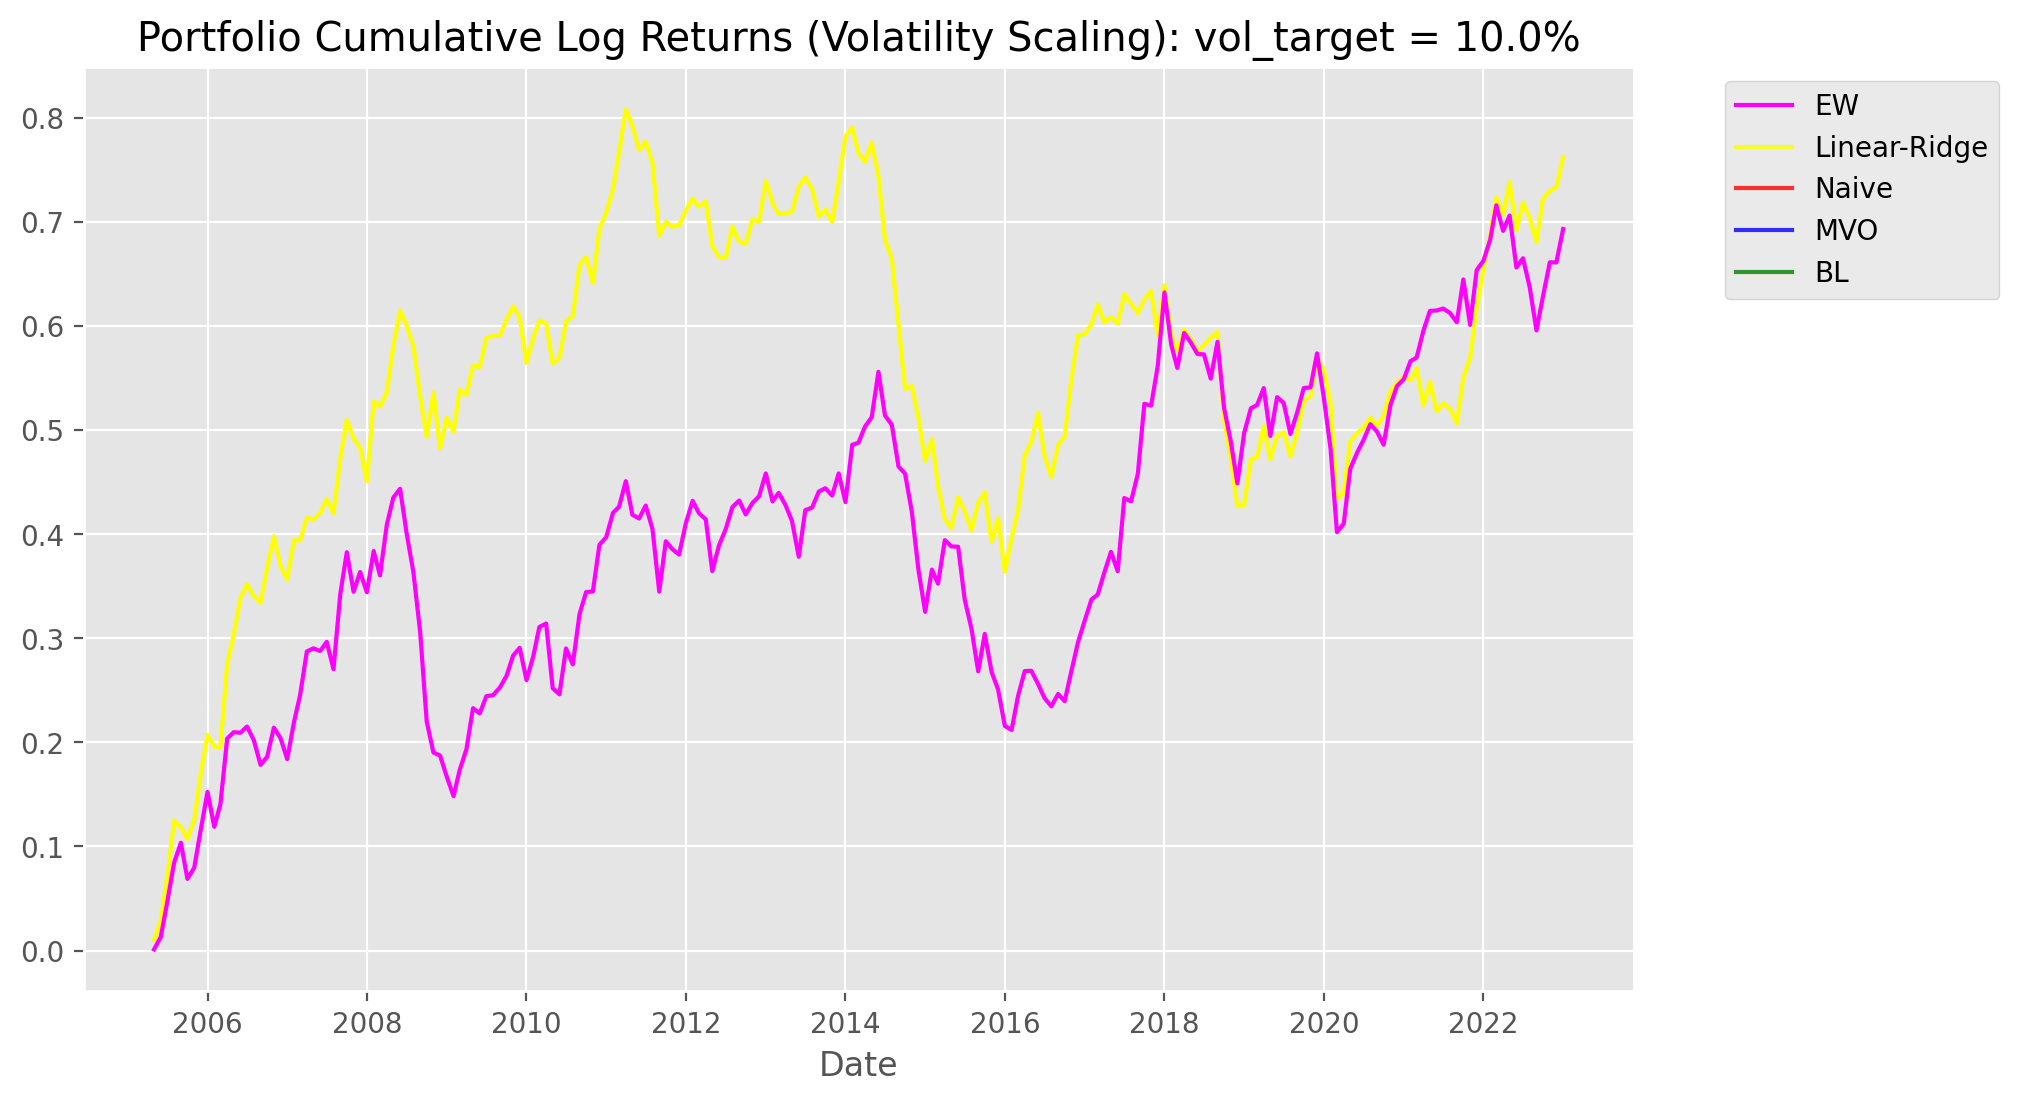

In [19]:
# Group models
linear_ridge_models = [m for m in returns.columns if (m.startswith('linear-ridge')) and (not m.endswith('rand'))]
naive_models = [m for m in returns.columns if (m.startswith('naive')) and (not m.endswith('rand'))]
mvo_models = [m for m in returns.columns if (m.startswith('mvo')) and (not m.endswith('rand'))]
bl_models = [m for m in returns.columns if (m.startswith('bl')) and (not m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group
for model in linear_ridge_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='yellow', alpha=1)
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)
for model in bl_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='green', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='magenta', label='EW')
# plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='cyan', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='yellow', label='Linear-Ridge', alpha=0.8)
plt.plot([], [], color='red', label='Naive', alpha=0.8)
plt.plot([], [], color='blue', label='MVO', alpha=0.8)
plt.plot([], [], color='green', label='BL', alpha=0.8)

plt.title(f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [20]:
super_benchmarks = ['ew']
selected_model_list = [
    'naive_lns_2',
    'naive_mx_2',
    'naive_los_2',
    'naive_lo_2',
    'naive_lns_3',
    'naive_mx_3',
    'naive_los_3',
    'naive_lo_3',
    'naive_mx_4',
    'naive_lns_4',
    'naive_los_4',
    'naive_lo_4',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('naive')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='blue', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='blue', label='Naive', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Naive Regime Portfolio (naive) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

KeyError: "['naive_lns_2', 'naive_mx_2', 'naive_los_2', 'naive_lo_2', 'naive_lns_3', 'naive_mx_3', 'naive_los_3', 'naive_lo_3', 'naive_mx_4', 'naive_lns_4', 'naive_los_4', 'naive_lo_4', 'mvo_lns_2', 'mvo_lo_2', 'mvo_lns_3', 'mvo_lo_3', 'mvo_lns_4', 'mvo_lo_4'] not in index"

In [21]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
linear-ridge_lo_5,3.738,17.414,0.744,2.043,-2.063,-10.946,0.569


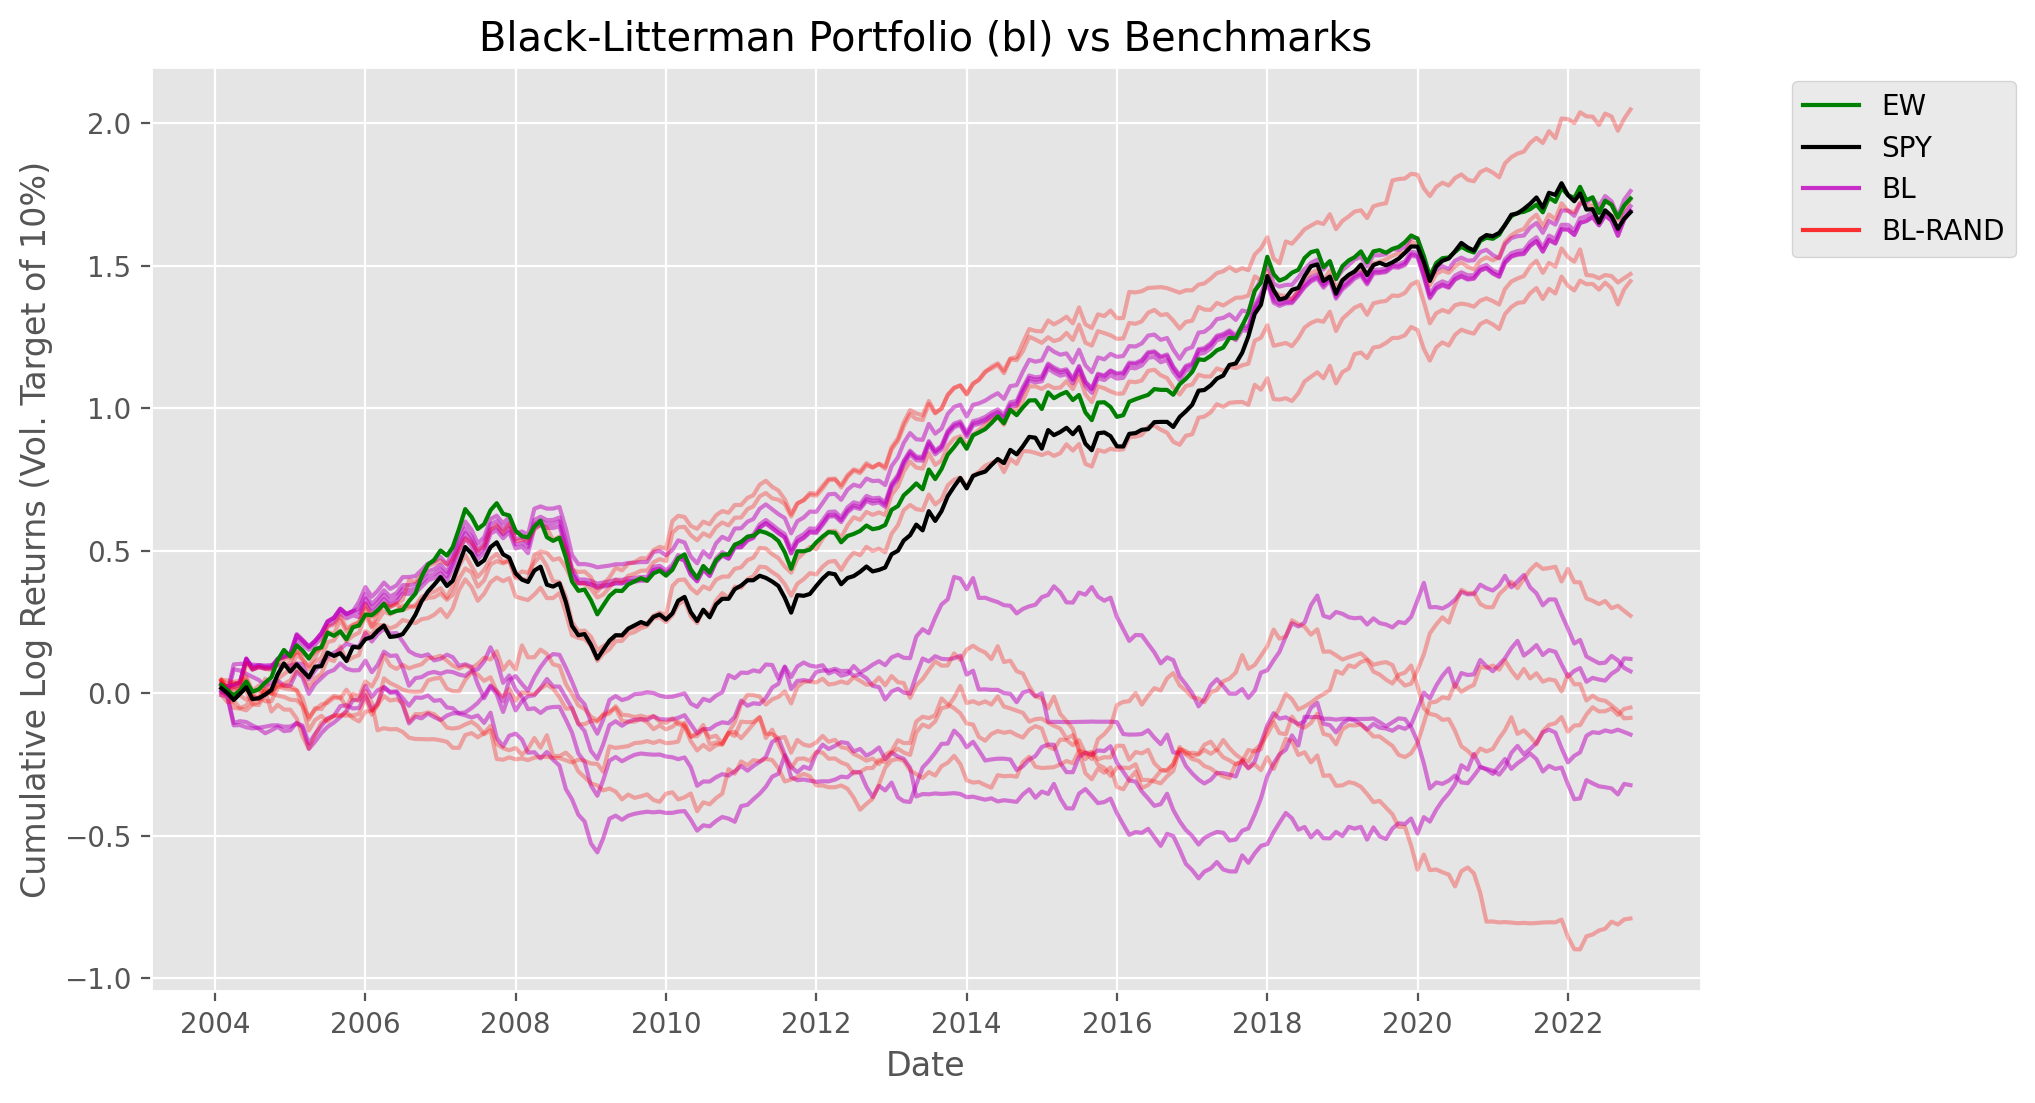

In [ ]:
super_benchmarks = ['spy', 'ew']
selected_model_list = [
    'bl_lns_2',
    'bl_lo_2',
    'bl_lns_3',
    'bl_lo_3',
    'bl_lns_4',
    'bl_lo_4',
    'bl_lns_5',
    'bl_lo_5',

    'bl_lns_2_rand',
    'bl_lo_2_rand',
    'bl_lns_3_rand',
    'bl_lo_3_rand',
    'bl_lns_4_rand',
    'bl_lo_4_rand',
    'bl_lns_5_rand',
    'bl_lo_5_rand',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if (m.startswith('bl')) and (not m.endswith('rand'))]
mvo_models = [m for m in selected_model_list if (m.endswith('rand'))]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='m', alpha=0.5)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='m', label='BL', alpha=0.8)
plt.plot([], [], color='red', label='BL-RAND', alpha=0.8)

plt.title(f"Black-Litterman Portfolio (bl) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [18]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
bl_lns_2,3.531,31.347,0.390,1.507,-5.093,-17.926,0.522
bl_lo_2,4.591,13.512,1.177,1.744,-0.944,-8.636,0.665
bl_lns_3,0.144,21.980,0.023,0.023,-7.968,-26.081,0.518
bl_lo_3,4.388,14.198,1.071,1.306,-1.154,-10.612,0.670
bl_lns_4,0.639,23.006,0.096,0.130,-10.386,-24.185,0.487
bl_lo_4,4.350,13.614,1.107,1.479,-1.070,-9.620,0.656
bl_lns_5,1.035,13.921,0.257,0.478,-5.803,-15.949,0.496
bl_lo_5,4.165,15.353,0.940,0.956,-1.433,-13.203,0.652
bl_lns_2_rand,-1.029,12.797,-0.279,-0.388,-8.339,-18.502,0.473
bl_lo_2_rand,3.116,11.952,0.903,1.479,-1.063,-7.376,0.616


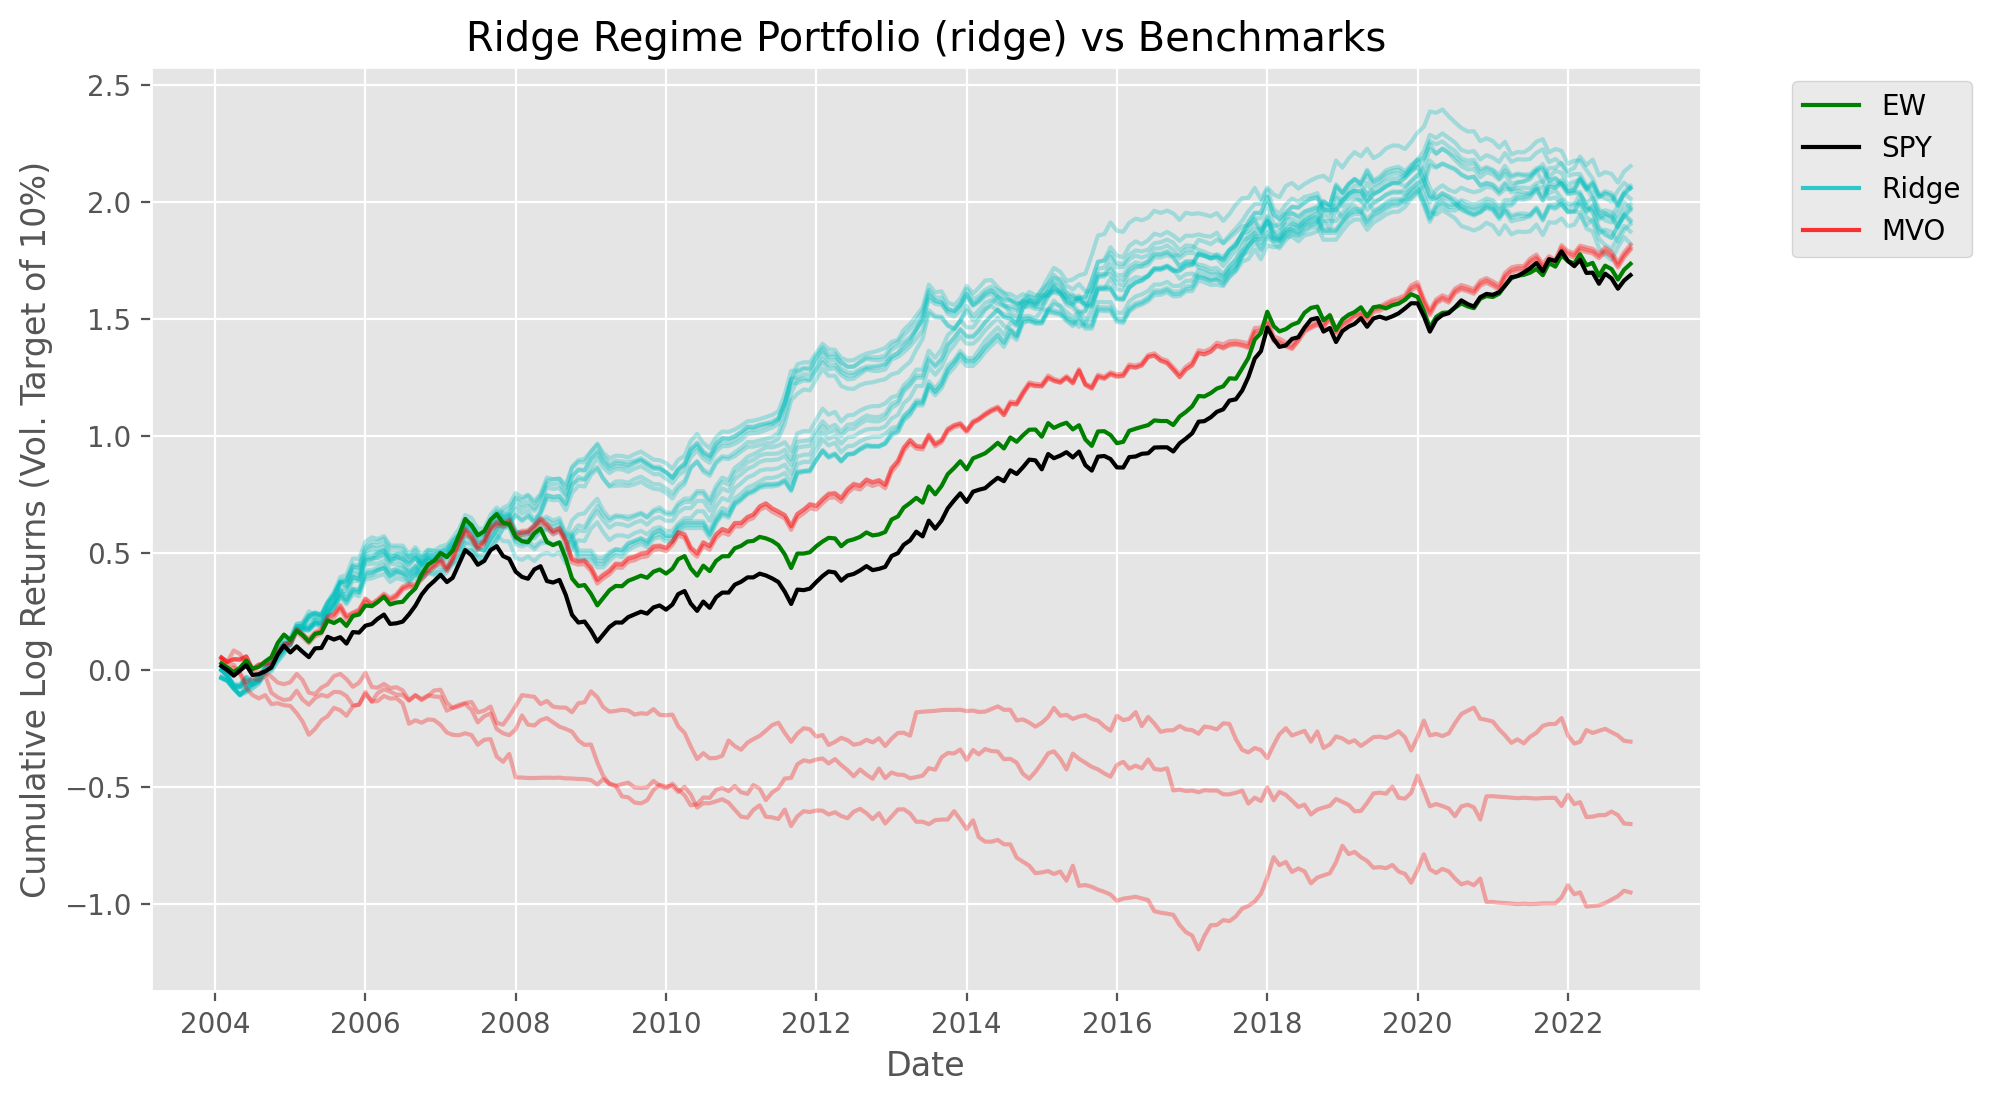

In [19]:
super_benchmarks = ['spy', 'ew']
selected_model_list = [
    'linear-ridge_lns_2',
    'linear-ridge_mx_2',
    'linear-ridge_los_2',
    'linear-ridge_lo_2',
    'linear-ridge_lns_3',
    'linear-ridge_mx_3',
    'linear-ridge_los_3',
    'linear-ridge_lo_3',
    'linear-ridge_lns_4',
    'linear-ridge_mx_4',
    'linear-ridge_los_4',
    'linear-ridge_lo_4',
   'linear-ridge_mx_5',
    'linear-ridge_los_5',
    'linear-ridge_lo_5',

    'mvo_lns_2',
    'mvo_lo_2',
    'mvo_lns_3',
    'mvo_lo_3',
    'mvo_lns_4',
    'mvo_lo_4',
]

returns = pd.concat(concat_list, axis=1).copy()[selected_model_list + super_benchmarks]
cum_returns_plot = returns.cumsum()

# Volatility scaling
vol_target = 0.10
portfolio_vol = vol_target / (returns.rolling(window=12).std().bfill() * np.sqrt(12))
voladj_returns = (returns * portfolio_vol).dropna()
cum_voladj_returns = voladj_returns.cumsum()
order = cum_voladj_returns.mean(axis=0).sort_values(ascending=False).index

# Group models 
naive_models = [m for m in selected_model_list if m.startswith('linear-ridge')]
mvo_models = [m for m in selected_model_list if m.startswith('mvo')]

# Define colors for each group
colors = {
   'linear-ridge': 'red',
   'mvo': 'blue', 
   'ew': 'green',
   'spy': 'black'
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in naive_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='c', alpha=0.3)

# Plot mvo models in red  
for model in mvo_models:
   plt.plot(cum_voladj_returns.index, cum_voladj_returns[model], color='red', alpha=0.3)

# Plot benchmarks
plt.plot(cum_voladj_returns.index, cum_voladj_returns['ew'], color='green', label='EW')
plt.plot(cum_voladj_returns.index, cum_voladj_returns['spy'], color='black', label='SPY')

# Add representative lines for legend
plt.plot([], [], color='c', label='Ridge', alpha=0.8)
plt.plot([], [], color='red', label='MVO', alpha=0.8)

plt.title(f"Ridge Regime Portfolio (ridge) vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 10%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [20]:
selected_summary_statistics = []
for model in cum_voladj_returns.columns:
    if model not in super_benchmarks:
        summary_statistics = pd.DataFrame([all_summary_statistics_df.loc[model]], index=[model])
        selected_summary_statistics.append(summary_statistics)
selected_summary_statistics_df = pd.concat(selected_summary_statistics)

selected_summary_statistics_df.round(3)

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
linear-ridge_lns_2,5.629,29.270,0.666,0.718,-3.668,-27.020,0.621
linear-ridge_mx_2,6.966,23.773,1.015,2.865,-1.786,-12.300,0.612
linear-ridge_los_2,6.297,24.914,0.876,2.127,-1.722,-9.926,0.621
linear-ridge_lo_2,7.667,23.414,1.134,4.449,-0.675,-4.389,0.607
linear-ridge_lns_3,6.206,22.569,0.953,2.977,-1.816,-13.266,0.594
linear-ridge_mx_3,5.051,13.159,1.330,2.674,-1.403,-7.795,0.598
linear-ridge_los_3,6.831,22.517,1.051,3.322,-1.555,-10.976,0.621
linear-ridge_lo_3,5.628,12.953,1.505,3.170,-0.700,-4.386,0.594
linear-ridge_lns_4,6.444,23.107,0.966,3.067,-2.026,-14.090,0.580
linear-ridge_mx_4,5.176,13.757,1.303,2.554,-1.673,-10.470,0.589


## Nemenyi Test

In [21]:
def nemenyi_test(metric_values, control, treatment, alpha=0.05):
   # Prepare data matrix where rows are samples and columns are methods
   data = np.array([metric_values[control], metric_values[treatment]]).T
   
   # Calculate ranks for each row
   ranks = np.array([stats.rankdata(row) for row in data])
   mean_ranks = np.mean(ranks, axis=0)
   
   # Calculate critical distance
   k = 2  # number of methods being compared
   n = len(control)  # number of samples
   q = stats.studentized_range.ppf(1 - alpha, k, np.inf) / np.sqrt(2)
   cd = q * np.sqrt((k * (k + 1)) / (6 * n))
   
   return mean_ranks, cd

In [22]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.333           1.667    0.082
1          Sortino         1.167           1.833    0.019
2            MaxDD         1.500           1.500    0.480
3  % Positive Ret.         1.250           1.750    0.046


In [23]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["bl_lns_2_rand", "bl_lo_2_rand", "bl_lns_3_rand", "bl_lo_3_rand", "bl_lns_4_rand", "bl_lo_4_rand"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.333           1.667    0.068
1          Sortino         1.500           1.500    0.295
2            MaxDD         1.667           1.333    0.394
3  % Positive Ret.         1.083           1.917    0.003


In [30]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = [
    "linear-ridge_lo_2_rand", "linear-ridge_lo_3_rand", "linear-ridge_lo_4_rand", 
    "linear-ridge_lns_3_rand", "linear-ridge_lns_2_rand",  "linear-ridge_lns_4_rand", 
    "linear-ridge_los_3_rand", "linear-ridge_los_2_rand",  "linear-ridge_los_4_rand", 
    "linear-ridge_mx_3_rand", "linear-ridge_mx_2_rand",  "linear-ridge_mx_4_rand", 
]
treatment = [
    "linear-ridge_lo_2", "linear-ridge_lo_3", "linear-ridge_lo_4", 
    "linear-ridge_lns_3", "linear-ridge_lns_2",  "linear-ridge_lns_4", 
    "linear-ridge_los_3", "linear-ridge_los_2",  "linear-ridge_los_4", 
    "linear-ridge_mx_3", "linear-ridge_mx_2",  "linear-ridge_mx_4", 
]

results = []
for metric_name in metric_names:
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   mean_ranks, cd = nemenyi_test(metric_values, control, treatment)
   
   # T-test
   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   results.append({
       'Metric': metric_name,
       'Control Rank': mean_ranks[0],
       'Treatment Rank': mean_ranks[1],
    #    'Critical Distance': cd,
       'p-value': p_value
   })

results_df = pd.DataFrame(results)
print(results_df.to_string(float_format=lambda x: '{:.3f}'.format(x)))

            Metric  Control Rank  Treatment Rank  p-value
0           Sharpe         1.000           2.000    0.000
1          Sortino         1.167           1.833    0.010
2            MaxDD         1.583           1.417    0.880
3  % Positive Ret.         1.083           1.917    0.000


## T-test for Two Related Samples ($H_0: \mu_c > \mu_t$)

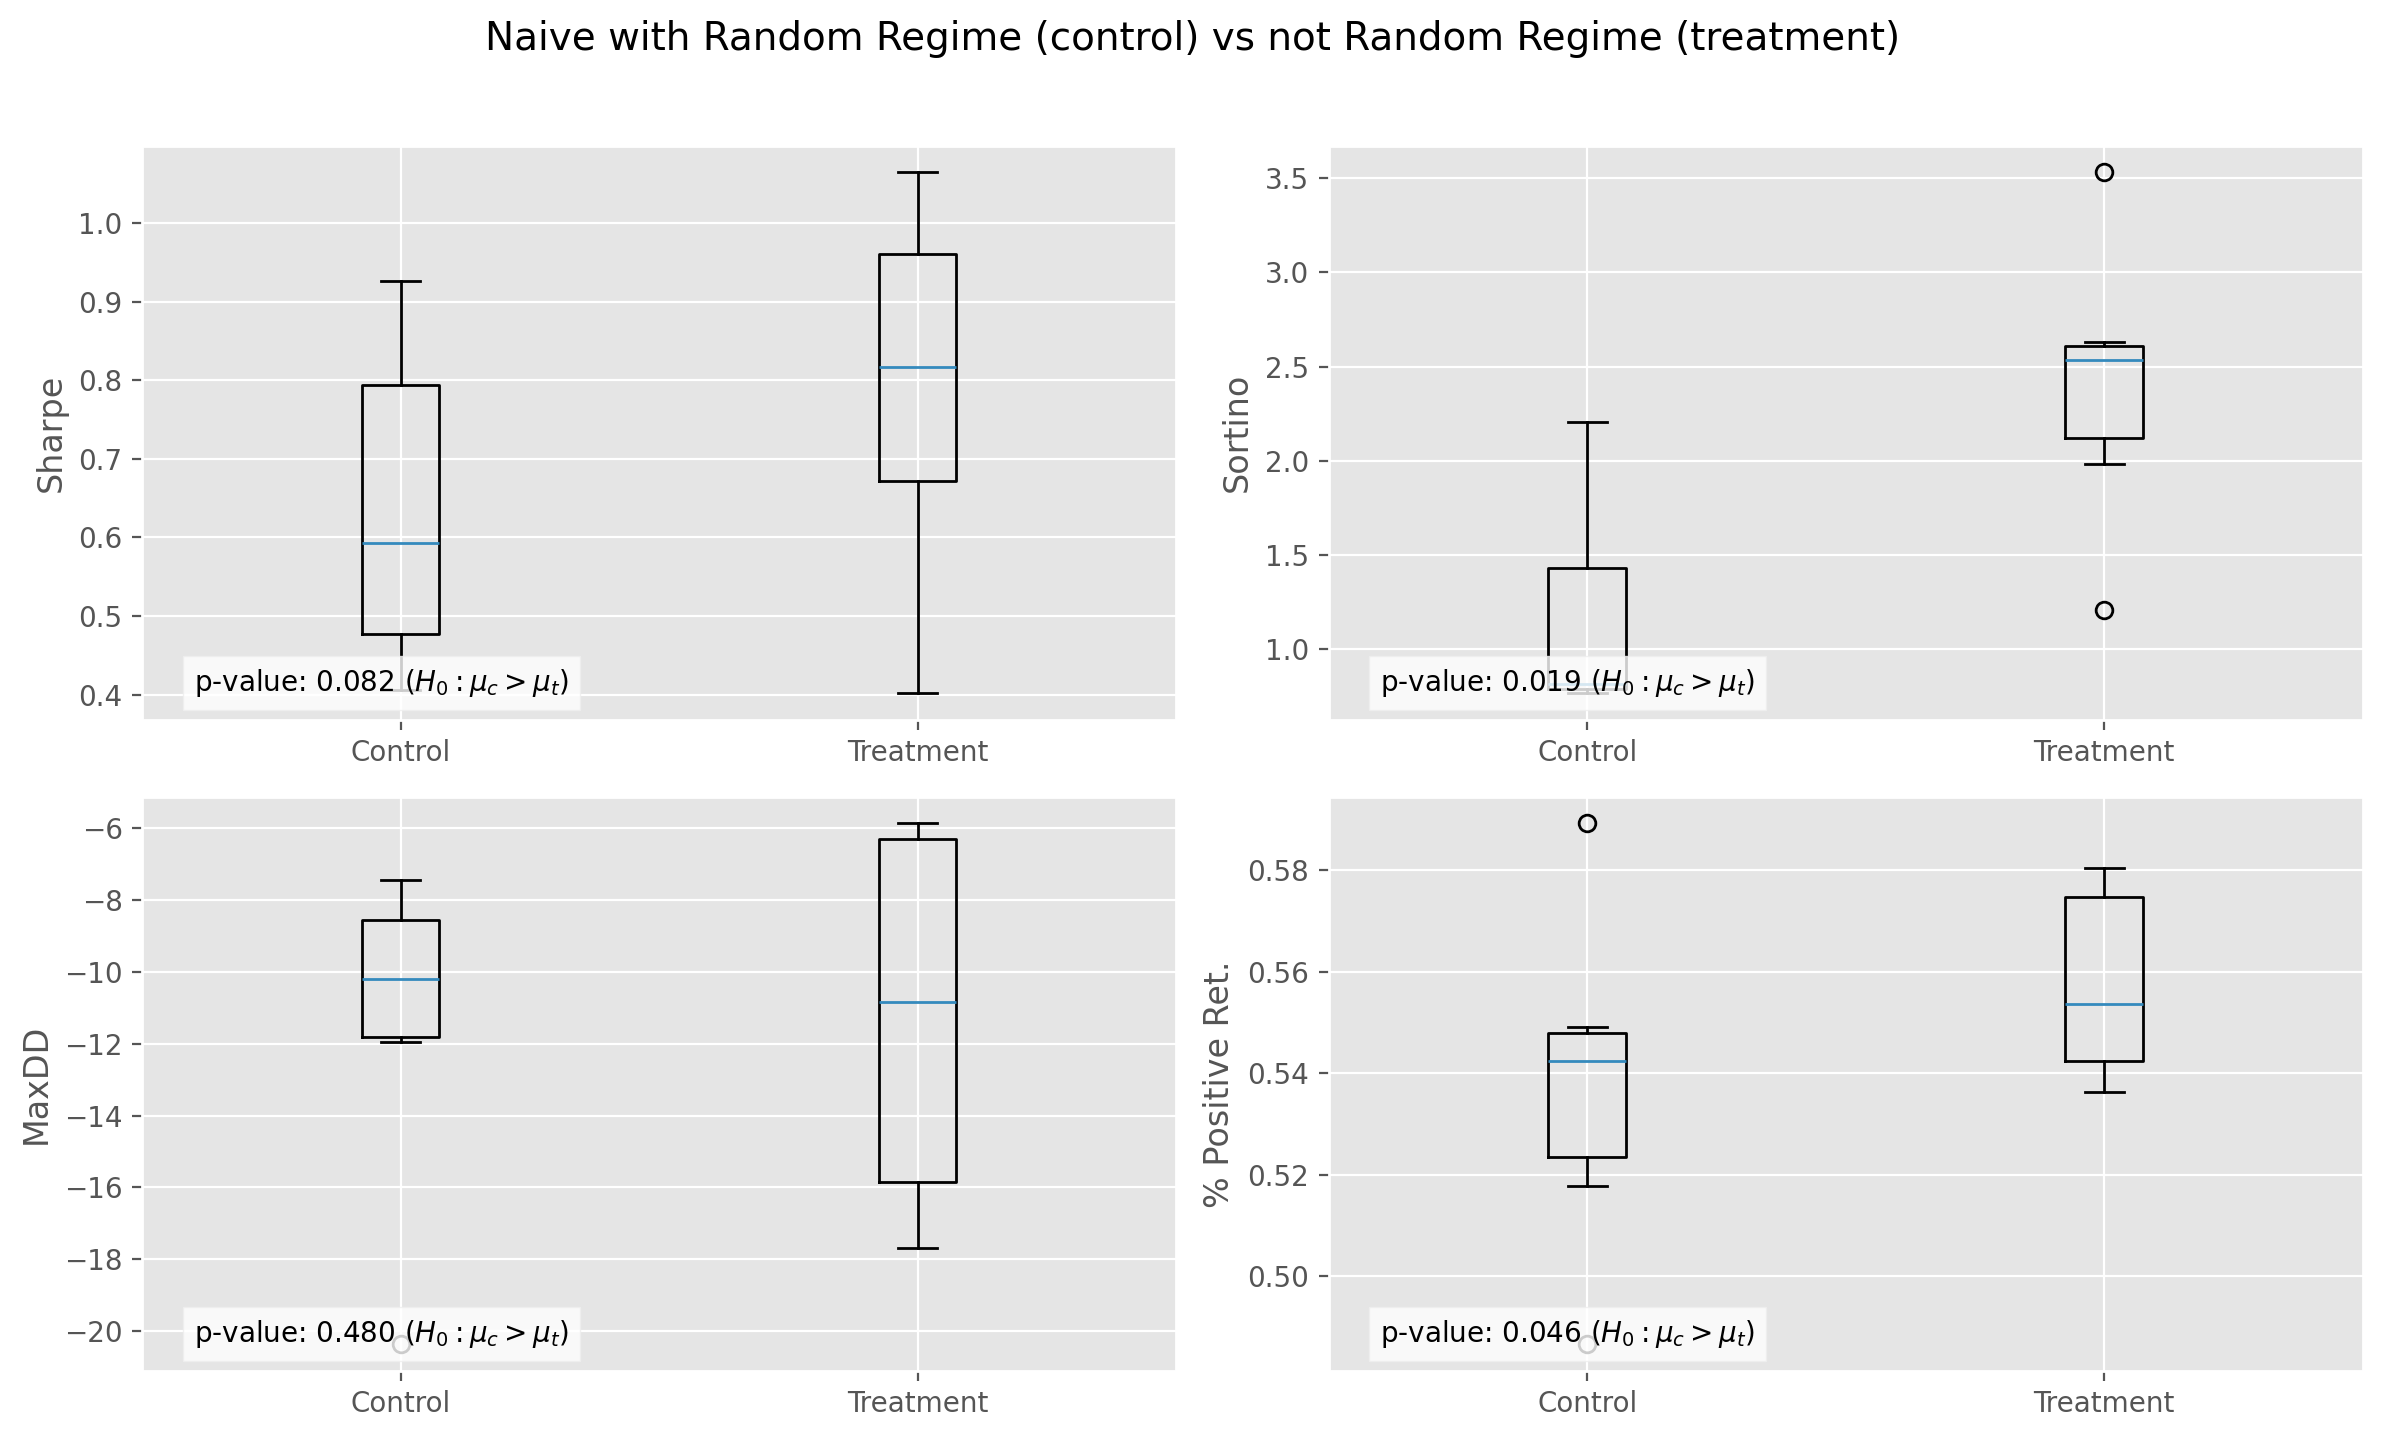

In [31]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["naive_lns_2_rand", "naive_lo_2_rand", "naive_lns_3_rand", "naive_lo_3_rand", "naive_lns_4_rand", "naive_lo_4_rand"]
treatment = ["naive_lns_2", "naive_lo_2", "naive_lns_3", "naive_lo_3", "naive_lns_4", "naive_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Naive with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

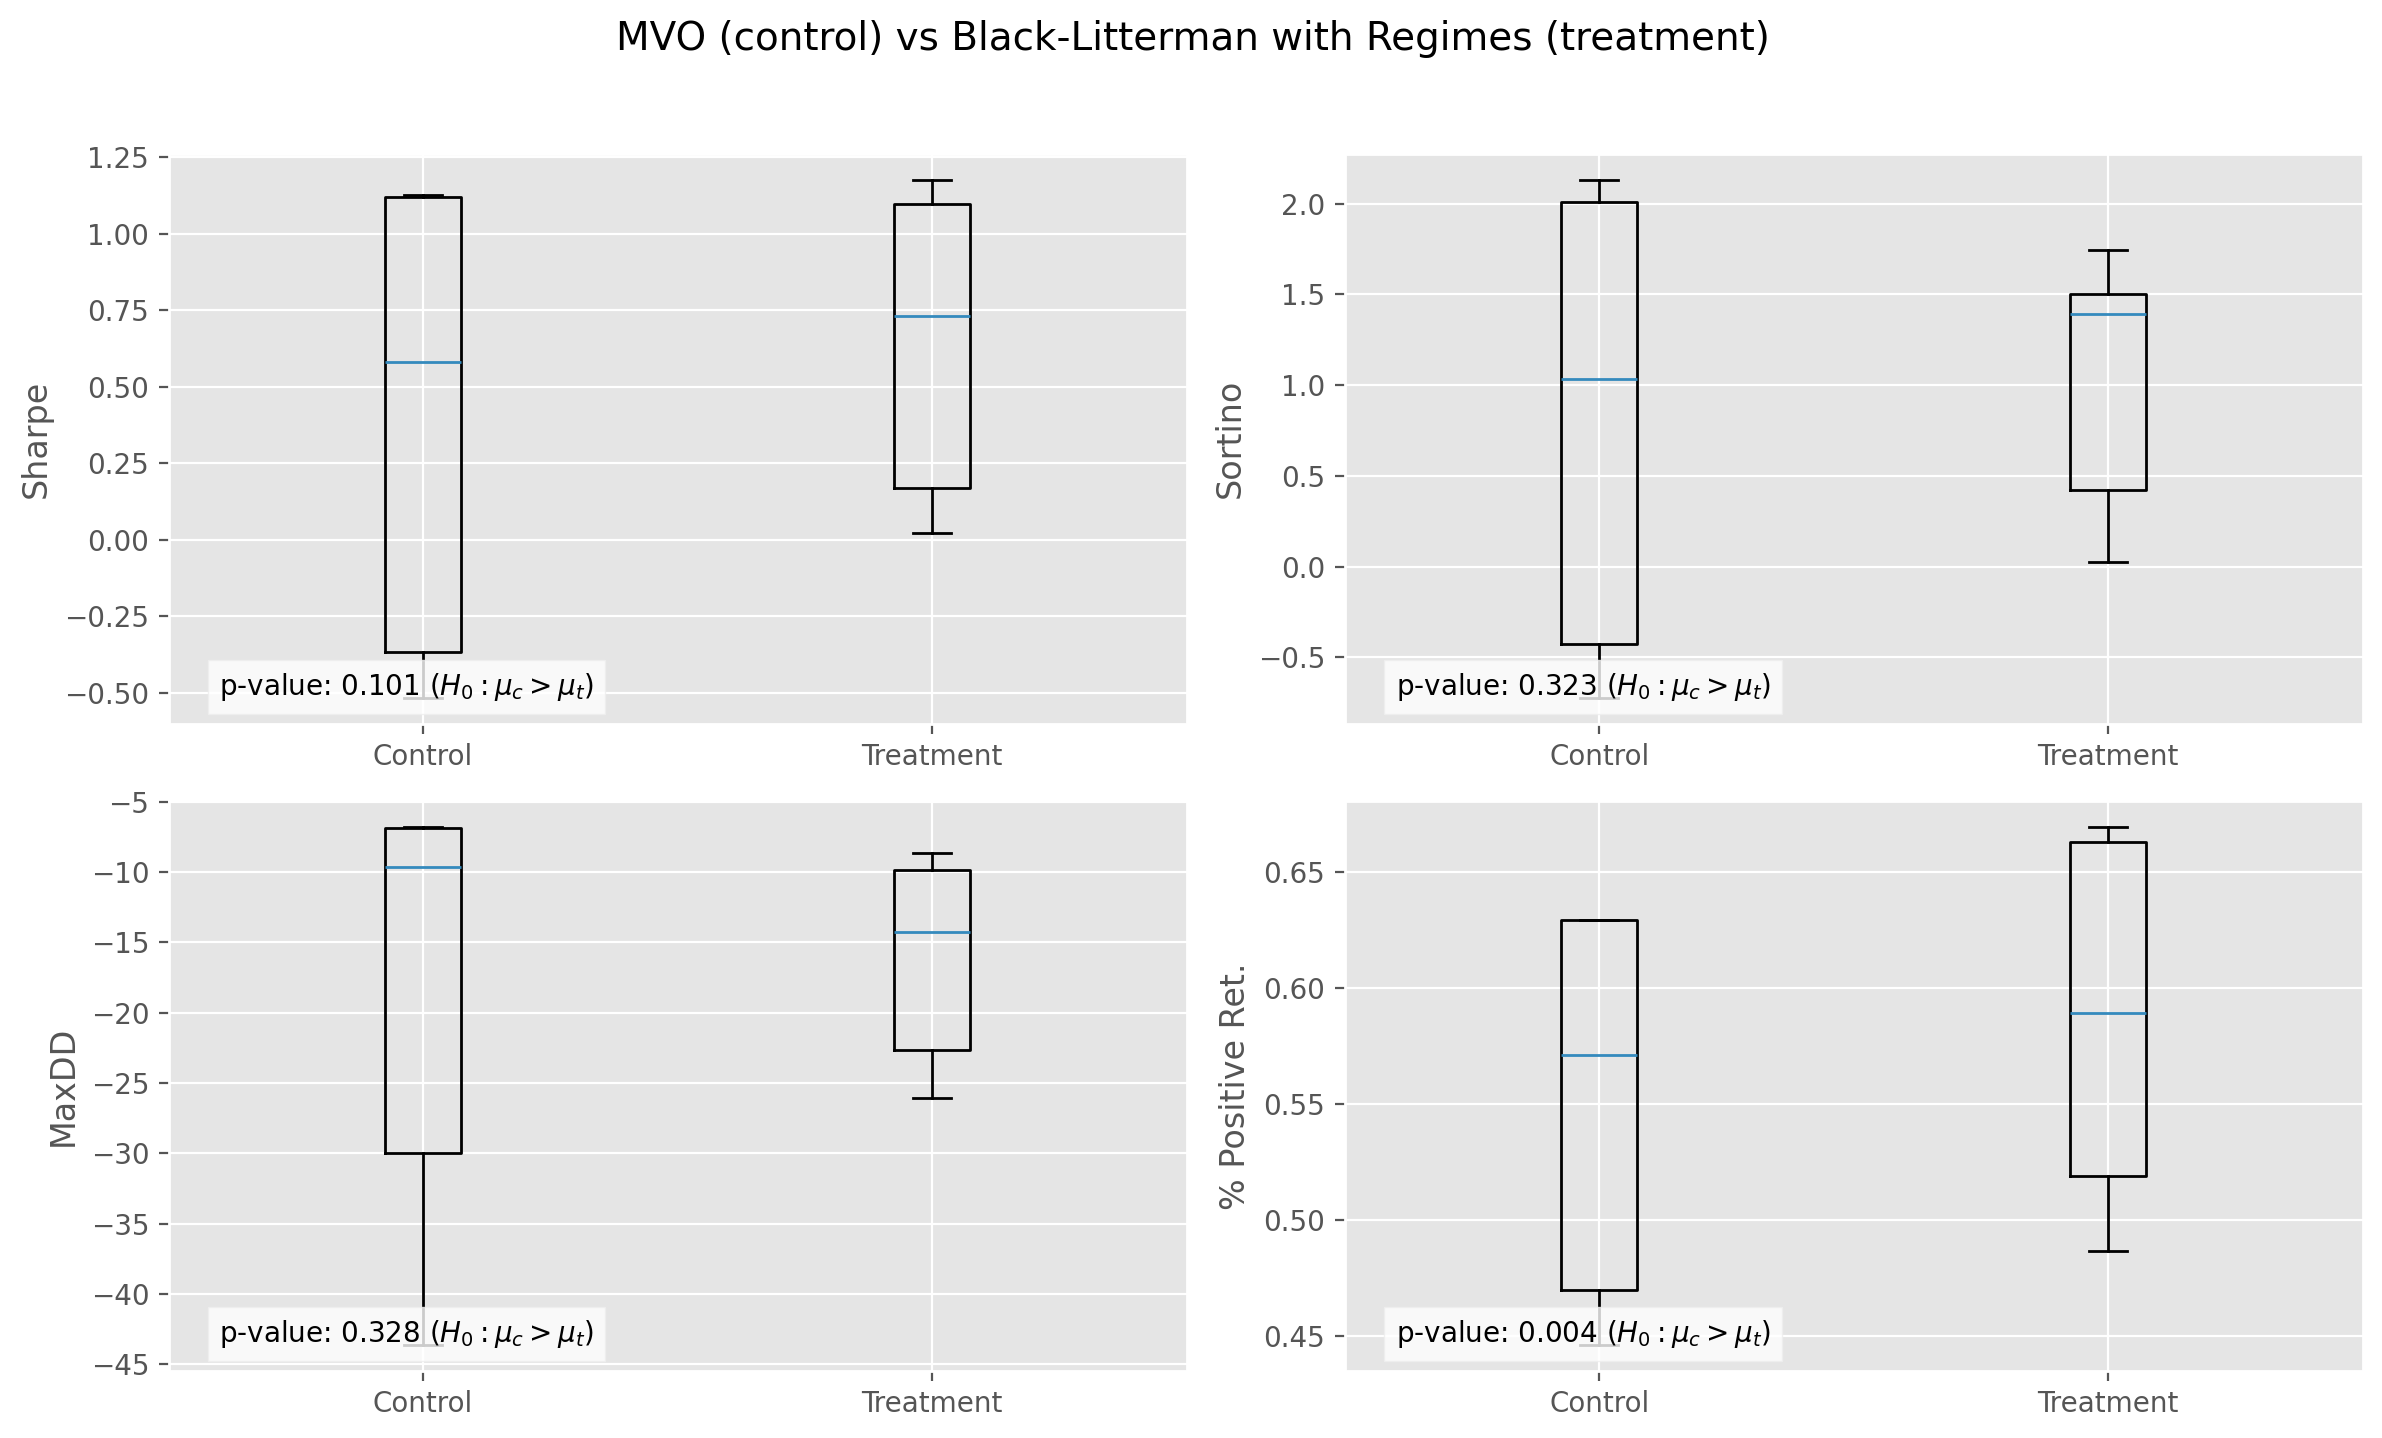

In [32]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = ["mvo_lns_2", "mvo_lo_2", "mvo_lns_3", "mvo_lo_3", "mvo_lns_4", "mvo_lo_4"]
treatment = ["bl_lns_2", "bl_lo_2", "bl_lns_3", "bl_lo_3", "bl_lns_4", "bl_lo_4"]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('MVO (control) vs Black-Litterman with Regimes (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

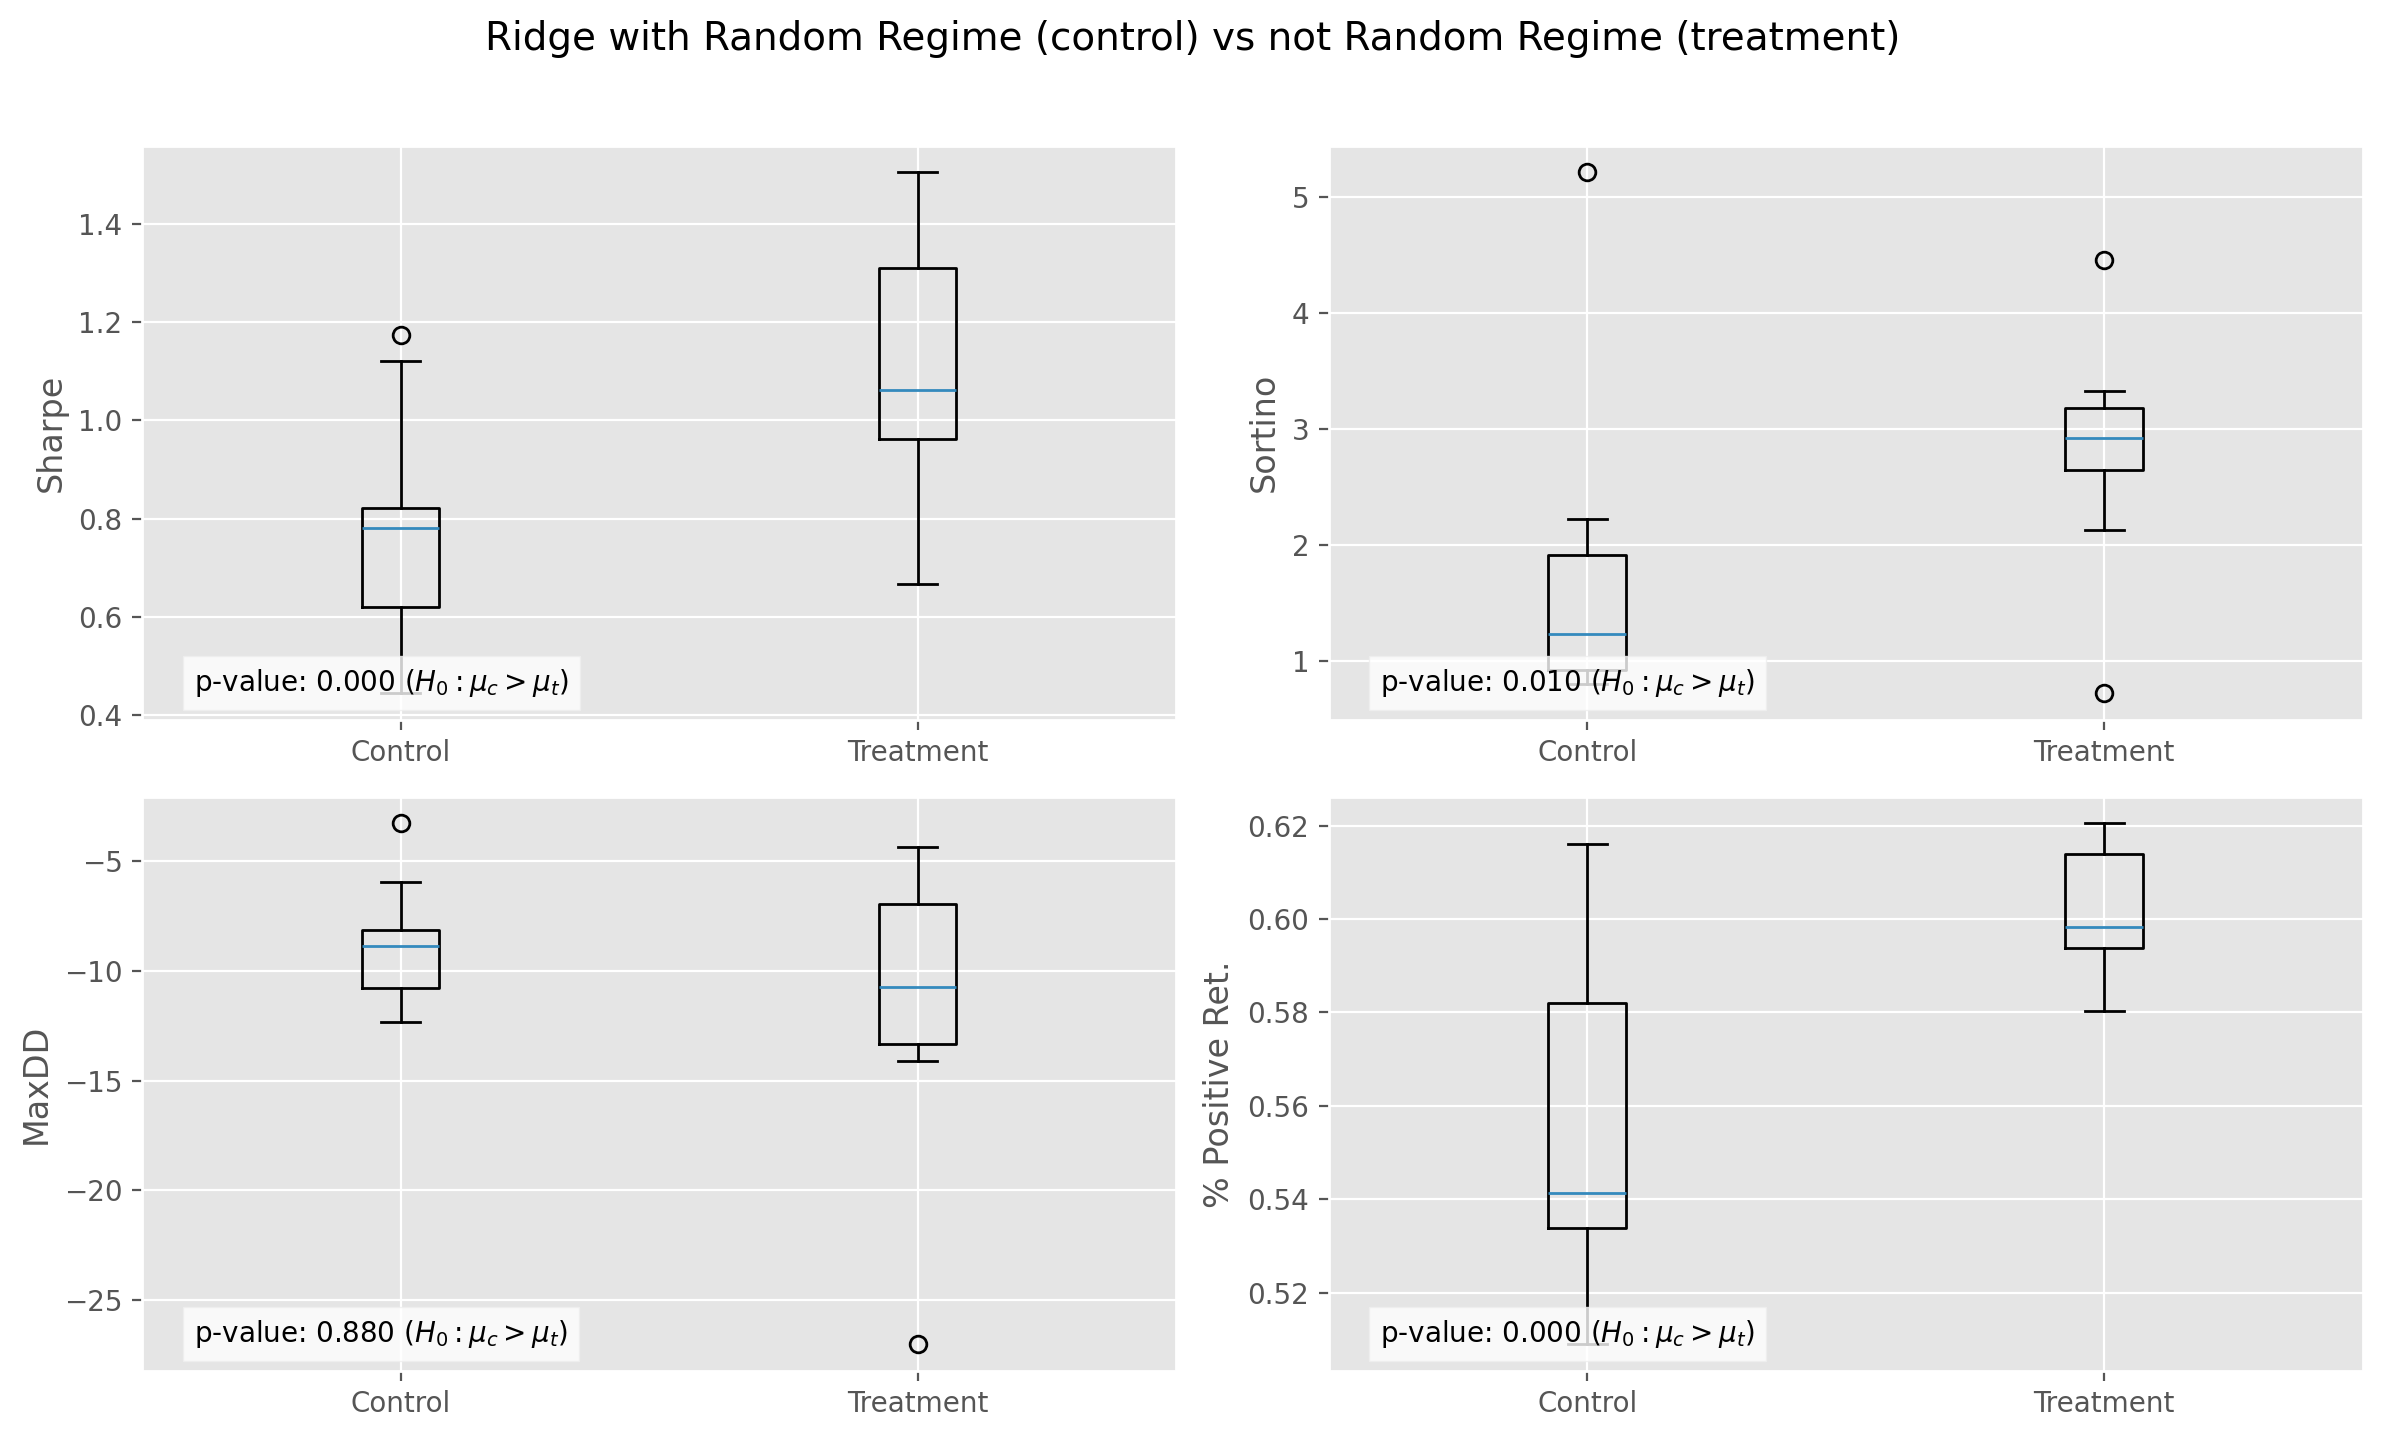

In [33]:
metric_names = ["Sharpe", "Sortino", "MaxDD", "% Positive Ret."]
control = [
    "linear-ridge_lo_2_rand", "linear-ridge_lo_3_rand", "linear-ridge_lo_4_rand", 
    "linear-ridge_lns_3_rand", "linear-ridge_lns_2_rand",  "linear-ridge_lns_4_rand", 
    "linear-ridge_los_3_rand", "linear-ridge_los_2_rand",  "linear-ridge_los_4_rand", 
    "linear-ridge_mx_3_rand", "linear-ridge_mx_2_rand",  "linear-ridge_mx_4_rand", 
]
treatment = [
    "linear-ridge_lo_2", "linear-ridge_lo_3", "linear-ridge_lo_4", 
    "linear-ridge_lns_3", "linear-ridge_lns_2",  "linear-ridge_lns_4", 
    "linear-ridge_los_3", "linear-ridge_los_2",  "linear-ridge_los_4", 
    "linear-ridge_mx_3", "linear-ridge_mx_2",  "linear-ridge_mx_4", 
]

fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

fig.suptitle('Ridge with Random Regime (control) vs not Random Regime (treatment)', fontsize=14, y=1.02)
for i, metric_name in enumerate(metric_names):
   metric_values = all_summary_statistics_df.loc[control+treatment][metric_name]
   data = [metric_values[control], metric_values[treatment]]
   
   axes[i].boxplot(data, tick_labels=['Control', 'Treatment'])
   # axes[i].set_title(metric_name)
   axes[i].set_ylabel(metric_name)
   axes[i].grid(True)

   group1 = metric_values[control]
   group2 = metric_values[treatment]
   t_stat, p_value = stats.ttest_rel(group2, group1, alternative='greater')
   
   axes[i].text(0.05, 0.05, f'p-value: {p_value:.3f} ($H_0: \mu_c > \mu_t$)', 
               transform=axes[i].transAxes,
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()